# Classification d'images manuscrit de chiffres

In [1]:
#Import libraries et modules
import numpy as np
np.random.seed(123)  # pour la reproductibilité
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist 
import matplotlib.pyplot as plt

Using TensorFlow backend.


## On charge des données images = 70k images NB correspondant à des digits

In [2]:
#chargement des données mnist dans un train et test set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#Downloading data from https://s3.amazonaws.com/img-datasets/mnist.pkl.gz

print (X_train.shape)
print (X_test.shape)
#echantillons train de 60000 images de taille 28*28
#echantillons train de 10000 images de taille 28*28


(60000, 28, 28)
(10000, 28, 28)


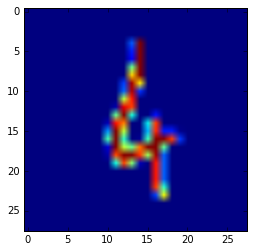

In [3]:
%matplotlib inline

plt.imshow(X_train[2220])

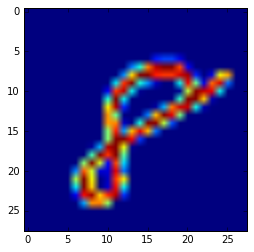

In [4]:
plt.imshow(X_train[59999])


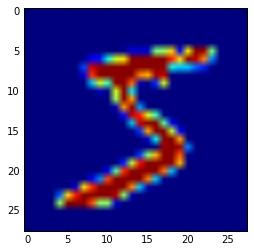

In [6]:
plt.imshow(X_train[0])

## pré-traitement des données : reshape et normalisation

Notre jeu de données MNIST a une profondeur de 1 et de taille 28 x 28 pixels
une image vaut entre 0 et 255 sur chaque pixel
Le but est de transformer notre jeu de données afin de lui ajouter une profondeur (profondeur*longueur*largeur)

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#Niveaux de gris des pixels vont de 0 à 255
#Normalisation pour avoir des valeurs entre 0 et 1 car une image prend des valeurs entre 0 et 255
X_train /= 255
X_test /= 255


In [6]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Pré traitement des labels 
On veut transformer nos labels en 10 classes. On veut que chaque classe soit codée sur un vecteur binaire de taille 10
Par exemple, le label du chiffre 1 sera codé de cette manière [0 1 0 0 0 0 0 0 0 0]
le chiffre 2 de cette manière [0 0 1 0 0 0 0 0 0 0] etc..

In [7]:
# convert class vectors to binary class matrices

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
print (y_train.shape)

(60000, 10)



##  Architecture de réseau profond de type CNN
 Entrée : 1 image 
 Couche 1 : 32 filtres => 32 images filtrées (feature map)
 Couche 2 : 32 filtres => 32 images filtrées (feature map)
 Couche 3 : pooling des 32 filtres  => 32 images filtrées (feature map) réduites
Couche 4 : flatten, chaque image est transformée en un vecteur 32 x taille image
 Couche 5 : fully connected de 128 neurones
Couche 6 : fully connected de 10 neurones



## principe de la convolution
chaque filter est différent et porte une info de type nuance, courbe, droite...
chaque filtre convolve autour de l'image input et lorsque il y a correspondance entre une portion de l'image
et le filtre alors il produit une valeur forte
chaque filtre revele ainsi des détails précis de l'image initial
chaque filtre revele des détails différents => se spécialise
pendant lapprentissage chaque filtre est appris indépendanmment
à la fin de la convolution, on peut ainsi avoir des filtres spécifiques à certains patterns de certains images
ils vont donc ensuite etre retenus comme des features importants pour tel type dimage

différence entre les filtres bas et filtre haut
les filtres bas détectent des low level features such as edges and curves.
mais pour prédire un objet, on doit détecter à un plus haut niveau les features comme une main, une oreille..
en sortie du premier conv, on voit localisés certains  low level features 


## On définit l'architecture du modèle
modele initialisé à vide

In [8]:
model = Sequential()

## ajout de traitement à notre séquence
Les 3 premiers arguments de la fonction Convolution2D correspondent au nombre de filtres utilisés sur chaque image
soit 32 et la taille du filtre soit 3*3
relu est la fonction d'activation appliquée à chaque filtre obtenu, d'autre fonction existe comme tanh ou sigmoid
En pratique relu présente les meilleurs perf.
Option border_mode à same pour du padding 

le premier param 32 est le nb de filtres, en sortie il y aura donc 32 features map de chaque image
input shape : image en NB ce que voit l'ordinateur est une matrice de 28 x 28 avec des chiffres

In [9]:
input_shape = (img_rows, img_cols, 1)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
# en sortie On a donc 32 représentations de l'image selon 32 filtres entrainés par le modele


model.add(Conv2D(64, (3, 3), activation='relu'))
# en sortie On a donc 64 représentations de l'image selon 64 filtres entrainés par le modele

#MaxPooling va segmenter les features map obtenu à l'étape précédente en bloc de 2*2 puis selectionner la valeur max 
#de chaque bloc
# en sortie ici on a une image deux fois moins grande
#le pooling permet de compresser limage en faisant ressortir que ce qui est important
model.add(MaxPooling2D(pool_size=(2,2)))
#le dropout annule certains coefficient il permet en général d'éviter de sur-apprendre
model.add(Dropout(0.25))
model.add(Flatten())
# le flatten consiste à créer une matrice contenant tous les features
# on voit qu'il y a 4608 parametres  car il y a 32 features map filtrées en entrée (32 représentations de l'image de 12 x 12)
# 32 x 12 x 12 = 4608
model.add(Dense(128, activation='relu'))
# nb de param = 128 biais + 128 x 4608 = 589952
# on ajoute une couche caché de fcc qui va etre reliee au flatten
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# on ajoute une couche qui relie la couche de 128 à une couche de 10 correspondant au nb de sorties
# cette couche prend en input et produit un vecteur à N dimensions,  N nb de classes à prédire
# chaque nb dans ce vecteur représente la proba de chaque classe

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [10]:
list_of_layers = model.layers
#print(list_of_layers[5]) # donne la 6e couche
list_of_layers[0].output_shape

(None, 26, 26, 32)

In [14]:
# couche flatten
print(list_of_layers[4])

## Il y a 1 199 k paramètres


* pour une couche  convnets  le nb de parametres = output_channels * (input_channels * window_size + 1) == number_parameters dans le premier, inputchanel = 1 car une image, output channel = 32, window size=3x3=9
* le flatten cree pour chaque image un vecteur de features, sa taille est 9216 soit le nb de pixel (12x12) x nb de filtres (64)
* pour une couche dense, le nb de parametres = output_size * (input_size + 1)
* première couche dense connecte donc les 9216 au 128 ce qui fait 1 179 648 + 128 =1 179 776
* dernière couche connecte les 128 neurones aux 10 = 128 x 10 + 10 = 1290

## Paramètres pour l'optimisation du réseau profond

In [16]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

## entrainement du modele
* batch size = 64 correspond la taille des lots de records qu'on utilise à chaque update du gradient (itération)
* epoch est le nombre de fois où l'algorithme voit tous les individus

In [23]:
batch_size=64
epochs = 5

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
60000/60000 [==============================] - 237s 4ms/step - loss: 0.2659 - acc: 0.9190
Epoch 2/5
60000/60000 [==============================] - 236s 4ms/step - loss: 0.1031 - acc: 0.9696
Epoch 3/5
60000/60000 [==============================] - 234s 4ms/step - loss: 0.0772 - acc: 0.9775
Epoch 4/5
60000/60000 [==============================] - 235s 4ms/step - loss: 0.0668 - acc: 0.9801
Epoch 5/5
60000/60000 [==============================] - 235s 4ms/step - loss: 0.0602 - acc: 0.9824


In [ ]:
batch_size=64
epochs = 1

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/1
19200/60000 [========>.....................] - ETA: 2:34 - loss: 0.5098 - acc: 0.8426

#  Occupation de la VM pendant l'apprentissage
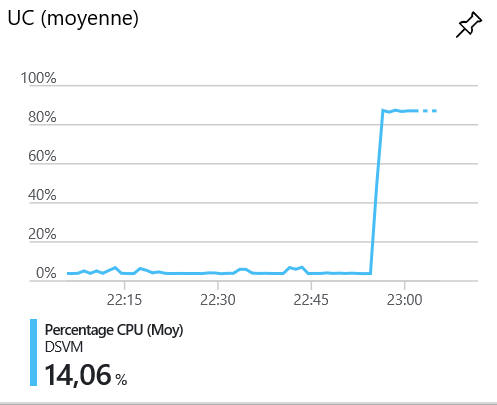

## Erreur de classement sur l'échantillon test

In [24]:
#pred = model.predict_classes(X_test)
#print ("score accuracy : ", np.where(pred == y_test,1,0).mean())

score accuracy :  0.0


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


## Métrique accuracy sur l'échantillon test = taux de bien classés

In [12]:
# Loss et bien classés sur l'échantillon test avec 5 epoch
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0505479794871
Test accuracy: 0.9839


#### 98,7 % de bien classés sur l'éch test

In [16]:
Y_pred = model.predict(X_test)
# Convert one-hot to index
y_pred = np.argmax(Y_pred, axis=1)
Y_pred.shape

(10000, 10)

In [15]:
y_test.shape

(10000, 10)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

ValueError: Mix type of y not allowed, got types {'multilabel-indicator', 'continuous-multioutput'}

## SAUVEGARDE DU MODELE

In [ ]:
from keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [ ]:
# serialize modele en JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")

In [ ]:
# si on veut utiliser le modèle
 
# chargement
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)